In [6]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

from config import get_cfg_defaults
from SequentialVAE import NeuralVAE, SeqDataLoader
from IPython.display import display, clear_output

# %matplotlib inline
# %matplotlib notebook

In [7]:
cfg = get_cfg_defaults()
data = h5py.File('data/poisson_obs.h5')
Y = torch.tensor(np.array(data['Y']), dtype=torch.float32)
X = torch.tensor(np.array(data['X']), dtype=torch.float32)
C = torch.tensor(np.array(data['C']), dtype=torch.float32)
b = torch.tensor(np.array(data['bias']), dtype=torch.float32)

n_epochs = 150
batch_size = 25
time_delta = 5e-3
n_latents = X.shape[2]
n_neurons = Y.shape[2]
n_time_bins = Y.shape[1]

In [8]:
vae = NeuralVAE(cfg, time_delta, n_neurons, n_latents, n_time_bins)
vae.manually_set_readout_params(C, b)

vae.decoder.C.bias.requires_grad_(False)
vae.decoder.C.weight.requires_grad_(False)
train_data_loader = SeqDataLoader((Y, X), batch_size)

opt = torch.optim.Adam(vae.parameters(), lr=1e-2)

In [9]:
def plot_vector_field(dynamics_fn, axs, axs_range):
    x = np.linspace(min(axs_range['x_min'], -1.5), max(axs_range['x_max'],1.5), 50)
    y = np.linspace(min(axs_range['y_min'], -1.5), max(axs_range['y_max'], 1.5), 50)

    X, Y = np.meshgrid(x, y)
    u, v = np.zeros(X.shape), np.zeros(Y.shape)
    NI, NJ = Y.shape

    for i in range(NI):
        for j in range(NJ):
            x = X[i, j]
            y = Y[i, j]

            vec_in = torch.tensor([x, y], dtype=torch.float32)
            vec_out = dynamics_fn(vec_in)
            s = (vec_out - vec_in).cpu().data.numpy()

            u[i, j] = s[0]
            v[i, j] = s[1]

    axs.streamplot(X, Y, u, v, color='black', linewidth=0.5, arrowsize=0.5)

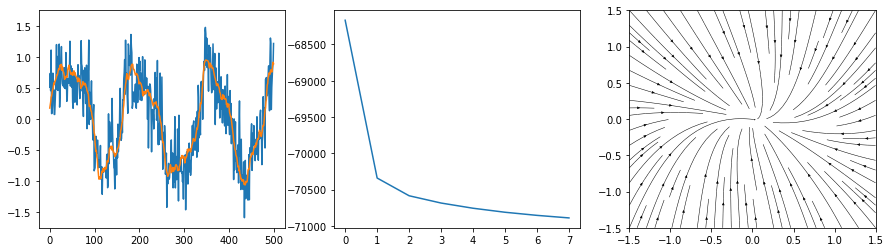

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(10, 3))
%matplotlib notebook
%matplotlib inline
# fig = plt.figure()
# axs = fig.add_subplot(1, 1, 1)
total_loss = []
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs_range = {'x_min': -1.5, 'x_max': 1.5,
             'y_min': -1.5, 'y_max': 1.5}


for epoch in range(n_epochs):
    batch_loss = []

    for batch_idx, (y, x) in enumerate(train_data_loader):
        loss, z, mu_t, log_var_t = vae(y, y, 1.0)
        batch_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0, norm_type=2)
        opt.step()
        opt.zero_grad()

    total_loss.append(np.mean(batch_loss))

    if epoch % 1 == 0:
        axs[0].cla()
        axs[0].set_ylim(-1.75, 1.75)
        axs[0].plot(z[:, 0, 0].detach().numpy())
        axs[0].plot(x[0, :, 0].detach().numpy())

        axs[1].set_xlim(0, epoch)
        axs[1].cla()
        axs[1].plot(total_loss)

        display(fig)
        clear_output(wait=True)

    if epoch % 5 == 0:
        with torch.no_grad():
            axs[2].cla()
            dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])
            plot_vector_field(dynamics_fn, axs[2], axs_range)

dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])

In [ ]:
fig, axs = plt.subplots()
axs_range = {'x_min': -1.5, 'x_max': 1.5,
             'y_min': -1.5, 'y_max': 1.5}

dynamics_fn = torch.nn.Sequential(*[vae.decoder.p_mlp, vae.decoder.p_fc_mu])
plot_vector_field(dynamics_fn, axs, axs_range)